# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [7]:
# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime
import datetime
import pandas as pd
import re

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql.types import IntegerType

from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,  LinearSVC, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, StringIndexer, VectorAssembler , CountVectorizer, IDF, StopWordsRemover, RegexTokenizer, StandardScaler, VectorAssembler, PCA
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel



In [136]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Churn Analysis") \
    .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [137]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [138]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [139]:
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [140]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [141]:
df.describe().show()


+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [142]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [143]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [144]:
df.count()

286500

In [145]:
# drop any cells with missing user id or session id
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

# drop any cell that has an empty string in userId
df = df[df.userId != ""]

#df = df.dropDuplicates(subset = ['userId'])
df.count()

278154

In [146]:
# clearly represent registration and timestamp by creating new columns
ts2 = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
ts3 = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).hour)
ts4 = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).month)
ts5 = udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).year)
df = df.withColumn('new_registration', ts2('registration'))
df = df.withColumn('new_ts', ts2('ts'))
df = df.withColumn('new_hour', ts3('ts'))
df = df.withColumn('new_month', ts4('ts'))
df = df.withColumn('new_year', ts5('ts'))


In [147]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', new_registration='09-28-2018 22:22:42', new_ts='10-01-2018 00:01:57', new_hour='0', new_month='10', new_year='2018'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', new_registration='09-30-2018 18:20:30', 

In [148]:
#printing first 20 rows
pd.DataFrame(df.take(20), columns = df.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,song,status,ts,userAgent,userId,new_registration,new_ts,new_hour,new_month,new_year
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,09-28-2018 22:22:42,10-01-2018 00:01:57,0,10,2018
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,09-30-2018 18:20:30,10-01-2018 00:03:00,0,10,2018
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,09-28-2018 22:22:42,10-01-2018 00:06:34,0,10,2018
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,09-30-2018 18:20:30,10-01-2018 00:06:56,0,10,2018
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,09-28-2018 22:22:42,10-01-2018 00:11:16,0,10,2018
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,09-30-2018 18:20:30,10-01-2018 00:11:18,0,10,2018
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,09-30-2018 18:20:30,10-01-2018 00:14:46,0,10,2018
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,...,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,09-28-2018 22:22:42,10-01-2018 00:14:59,0,10,2018
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,...,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,09-28-2018 22:22:42,10-01-2018 00:15:05,0,10,2018
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,...,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,09-28-2018 22:22:42,10-01-2018 00:18:04,0,10,2018


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [149]:
#number of rows with active status
df.filter("page != 'Cancellation Confirmation'").select('userId').distinct().count()

225

In [150]:
#number of rows with cancelled status
df.filter("page == 'Cancellation Confirmation'").select('userId').distinct().count()

52

In [151]:
#explorer the churn with sparksql
#Create a temporary view to perform SQL operations
df.createOrReplaceTempView("Sparkify")
spark.sql('''
        SELECT userId, artist, page,song, level, new_ts
        FROM Sparkify
        where page == "Cancellation Confirmation"
''').show()


+------+------+--------------------+----+-----+-------------------+
|userId|artist|                page|song|level|             new_ts|
+------+------+--------------------+----+-----+-------------------+
|    18|  null|Cancellation Conf...|null| paid|10-07-2018 20:26:30|
|    32|  null|Cancellation Conf...|null| paid|10-08-2018 21:10:46|
|   125|  null|Cancellation Conf...|null| free|10-12-2018 04:35:18|
|   105|  null|Cancellation Conf...|null| paid|10-12-2018 20:17:21|
|    17|  null|Cancellation Conf...|null| paid|10-13-2018 21:19:44|
|   143|  null|Cancellation Conf...|null| free|10-15-2018 07:34:14|
|   101|  null|Cancellation Conf...|null| paid|10-16-2018 22:30:37|
|   129|  null|Cancellation Conf...|null| paid|10-17-2018 00:29:21|
|   121|  null|Cancellation Conf...|null| paid|10-17-2018 07:02:29|
|    51|  null|Cancellation Conf...|null| paid|10-17-2018 07:39:32|
|    87|  null|Cancellation Conf...|null| paid|10-20-2018 15:49:16|
|   122|  null|Cancellation Conf...|null| paid|1

In [152]:
#explore the churne
df.filter('page == "Cancellation Confirmation"').select(['userId','artist','page','song', 'level', 'new_ts']).show()

+------+------+--------------------+----+-----+-------------------+
|userId|artist|                page|song|level|             new_ts|
+------+------+--------------------+----+-----+-------------------+
|    18|  null|Cancellation Conf...|null| paid|10-07-2018 20:26:30|
|    32|  null|Cancellation Conf...|null| paid|10-08-2018 21:10:46|
|   125|  null|Cancellation Conf...|null| free|10-12-2018 04:35:18|
|   105|  null|Cancellation Conf...|null| paid|10-12-2018 20:17:21|
|    17|  null|Cancellation Conf...|null| paid|10-13-2018 21:19:44|
|   143|  null|Cancellation Conf...|null| free|10-15-2018 07:34:14|
|   101|  null|Cancellation Conf...|null| paid|10-16-2018 22:30:37|
|   129|  null|Cancellation Conf...|null| paid|10-17-2018 00:29:21|
|   121|  null|Cancellation Conf...|null| paid|10-17-2018 07:02:29|
|    51|  null|Cancellation Conf...|null| paid|10-17-2018 07:39:32|
|    87|  null|Cancellation Conf...|null| paid|10-20-2018 15:49:16|
|   122|  null|Cancellation Conf...|null| paid|1

In [153]:
#let's see the detailed data for 1 user by sql
df.createOrReplaceTempView("Sparkify")
spark.sql('''
        SELECT userId, artist, page,song, level, new_ts
        FROM Sparkify
        where userId == 51
''').collect()

[Row(userId='51', artist=None, page='Home', song=None, level='paid', new_ts='10-01-2018 12:57:12'),
 Row(userId='51', artist='Erykah Badu', page='NextSong', song='Window Seat', level='paid', new_ts='10-01-2018 12:57:29'),
 Row(userId='51', artist='BlÃ\x83Â¸f', page='NextSong', song='Niets Dan Dit', level='paid', new_ts='10-01-2018 13:02:18'),
 Row(userId='51', artist="Mousse T. Vs Hot 'n' Juicy", page='NextSong', song='Horny', level='paid', new_ts='10-01-2018 13:06:07'),
 Row(userId='51', artist='Miranda Lambert', page='NextSong', song='Me and Your Cigarettes', level='paid', new_ts='10-01-2018 13:09:11'),
 Row(userId='51', artist='BjÃ\x83Â¶rk', page='NextSong', song='Undo', level='paid', new_ts='10-01-2018 13:11:35'),
 Row(userId='51', artist='Chris Cagle', page='NextSong', song='Anywhere But Here', level='paid', new_ts='10-01-2018 13:17:23'),
 Row(userId='51', artist='Daft Punk', page='NextSong', song='Harder Better Faster Stronger', level='paid', new_ts='10-01-2018 13:21:26'),
 Row(u

In [154]:
#let's see the detailed data for 1 user
df.where("userId == 51").select(['userId','artist','page','song', 'level','new_ts']).collect()

[Row(userId='51', artist=None, page='Home', song=None, level='paid', new_ts='10-01-2018 12:57:12'),
 Row(userId='51', artist='Erykah Badu', page='NextSong', song='Window Seat', level='paid', new_ts='10-01-2018 12:57:29'),
 Row(userId='51', artist='BlÃ\x83Â¸f', page='NextSong', song='Niets Dan Dit', level='paid', new_ts='10-01-2018 13:02:18'),
 Row(userId='51', artist="Mousse T. Vs Hot 'n' Juicy", page='NextSong', song='Horny', level='paid', new_ts='10-01-2018 13:06:07'),
 Row(userId='51', artist='Miranda Lambert', page='NextSong', song='Me and Your Cigarettes', level='paid', new_ts='10-01-2018 13:09:11'),
 Row(userId='51', artist='BjÃ\x83Â¶rk', page='NextSong', song='Undo', level='paid', new_ts='10-01-2018 13:11:35'),
 Row(userId='51', artist='Chris Cagle', page='NextSong', song='Anywhere But Here', level='paid', new_ts='10-01-2018 13:17:23'),
 Row(userId='51', artist='Daft Punk', page='NextSong', song='Harder Better Faster Stronger', level='paid', new_ts='10-01-2018 13:21:26'),
 Row(u

In [155]:
# create  downgrade label
downgradeValue  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("downgradeValue", downgradeValue("page"))
# find all downgraded users and create userDowngrade column
dg_window = Window.partitionBy('UserId')
df = df.withColumn("userDowngrade", max('downgradeValue').over(dg_window))
df.toPandas()


,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts,userAgent,userId,new_registration,new_ts,new_hour,new_month,new_year,downgradeValue,userDowngrade
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 12:58:54,12,10,2018,0,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:02:16,13,10,2018,0,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:05:32,13,10,2018,0,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:05:33,13,10,2018,0,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:09:55,13,10,2018,0,0
5,LMFAO,Logged In,Darianna,F,5,Carpenter,183.74485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539004511000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:15:11,13,10,2018,0,0
6,OneRepublic,Logged In,Darianna,F,6,Carpenter,224.67873,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539004694000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:18:14,13,10,2018,0,0
7,Dwight Yoakam,Logged In,Darianna,F,7,Carpenter,239.30730,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539004918000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:21:58,13,10,2018,0,0
8,None,Logged In,Darianna,F,8,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,...,1539004961000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:22:41,13,10,2018,0,0
9,The Chordettes,Logged In,Darianna,F,9,Carpenter,142.41914,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,1539005157000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,09-27-2018 02:45:40,10-08-2018 13:25:57,13,10,2018,0,0


In [156]:
#spark.udf.register( "downgradeValue", lambda x: 1 if x=="Submitted Downgrade" else 0, IntegerType())
#spark.sql(''' select userId, artist ,page, song, level, new_ts, max(downgradeValue) OVER(PARTITION BY userId ) as userDowngrade2 From sparkify ''').toPandas()

In [157]:
# create churn label
churnValue = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn("churnValue", churnValue("page"))

# find all churned users and create a userChurn column  
churn_window = Window.partitionBy('UserId')
df= df.withColumn("userChurn", max('churnValue').over(churn_window))

# selecting few users to see
df.select(['userId', 'firstName', 'level','new_ts','userChurn', 'userDowngrade']).dropDuplicates(subset = ['userId']).show(10)

+------+---------+-----+-------------------+---------+-------------+
|userId|firstName|level|             new_ts|userChurn|userDowngrade|
+------+---------+-----+-------------------+---------+-------------+
|100010| Darianna| free|10-08-2018 12:58:54|        0|            0|
|200002|  Dominic| free|10-01-2018 11:30:30|        0|            0|
|   125|    Mason| free|10-12-2018 04:05:44|        1|            0|
|   124|   Nicole| paid|10-01-2018 15:17:10|        0|            0|
|    51|    Ethan| paid|10-01-2018 12:57:12|        1|            0|
|     7|   Maddox| free|10-03-2018 11:57:49|        0|            0|
|    15|    Panav| paid|10-01-2018 10:23:35|        0|            0|
|    54|    Alexi| paid|10-01-2018 00:32:10|        1|            1|
|   155|   Camila| free|11-02-2018 15:56:25|        0|            0|
|100014|  Rodrigo| paid|10-10-2018 13:12:16|        1|            0|
+------+---------+-----+-------------------+---------+-------------+
only showing top 10 rows



In [158]:
df.select(['userId', 'firstName', 'level','new_ts','userChurn', 'userDowngrade']).where(df.userId=='54').collect()

[Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:32:10', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:36:20', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:39:56', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:45:39', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:45:49', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:49:45', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:54:14', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 00:54:15', userChurn=1, userDowngrade=1),
 Row(userId='54', firstName='Alexi', level='paid', new_ts='10-01-2018 12:12:37', userChurn=1, userDowngr

In [159]:
df.count()

278154

In [160]:
#checking count of users churned/ non-churned
df.select(['userId','userChurn']).distinct().groupBy('userChurn').count().show()

+---------+-----+
|userChurn|count|
+---------+-----+
|        1|   52|
|        0|  173|
+---------+-----+



In [161]:
#try sparksql
#Create a temporary view to perform SQL operations
df.createOrReplaceTempView("new_sparkify")

In [162]:
#checking count of users churned/ non-churned
df.createOrReplaceTempView("new_sparkify")
spark.sql(''' select  userChurn, COUNT(DISTINCT userId) AS user_counts
              From new_sparkify 
              GROUP BY 1''').show()

+---------+-----------+
|userChurn|user_counts|
+---------+-----------+
|        1|         52|
|        0|        173|
+---------+-----------+



In [163]:
#number of songs played in each hour
songs_played_inHour = df.filter("page == 'NextSong'").groupBy("new_hour").count().sort(df.new_hour.cast("float")).show()


+--------+-----+
|new_hour|count|
+--------+-----+
|       0| 9062|
|       1| 8388|
|       2| 8336|
|       3| 8355|
|       4| 8147|
|       5| 8178|
|       6| 8054|
|       7| 8091|
|       8| 8253|
|       9| 8498|
|      10| 8882|
|      11| 8830|
|      12| 9326|
|      13| 9644|
|      14|10494|
|      15|11354|
|      16|11636|
|      17|11460|
|      18|11124|
|      19|10930|
+--------+-----+
only showing top 20 rows



### Explorer level

In [164]:
# which level customers churn more solution1
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        where page == "Cancellation Confirmation"
        GROUP BY level
        ORDER BY user_count DESC
''').show()

+-----+----------+
|level|user_count|
+-----+----------+
| paid|        31|
| free|        21|
+-----+----------+



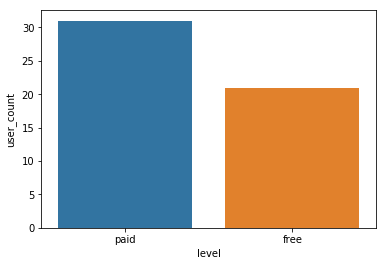

In [165]:
#explorer level column to see which level(paied or free) prefered to cancel 
# which level customers churn more solution1
leveldf1= spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        where page == "Cancellation Confirmation"
        GROUP BY level
        ORDER BY user_count DESC
''')
sns.barplot(data = leveldf1.toPandas(), x = 'level', y = 'user_count');

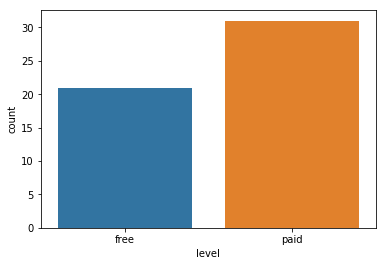

In [166]:
# which level customers churn more solution2
leveldf = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = leveldf, x = 'level', y = 'count');

### From the above plot, we can conclude that paid users are more likely to churn  comparing to free users

In [167]:
leveldf1= spark.sql('''
        SELECT userChurn,level,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        GROUP BY userChurn,level
        ORDER BY user_count DESC
''')
leveldf1.show()

+---------+-----+----------+
|userChurn|level|user_count|
+---------+-----+----------+
|        0| free|       149|
|        0| paid|       129|
|        1| free|        46|
|        1| paid|        36|
+---------+-----+----------+



In [168]:
spark.sql('''
        SELECT level,userChurn,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        GROUP BY 1,2
        ORDER BY user_count DESC
''').show()

+-----+---------+----------+
|level|userChurn|user_count|
+-----+---------+----------+
| free|        0|       149|
| paid|        0|       129|
| free|        1|        46|
| paid|        1|        36|
+-----+---------+----------+



In [169]:
user_churn_level = spark.sql('''
        SELECT userChurn,level,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        GROUP BY userChurn,level
        ORDER BY user_count DESC
''')
user_churn_level.show()

+---------+-----+----------+
|userChurn|level|user_count|
+---------+-----+----------+
|        0| free|       149|
|        0| paid|       129|
|        1| free|        46|
|        1| paid|        36|
+---------+-----+----------+



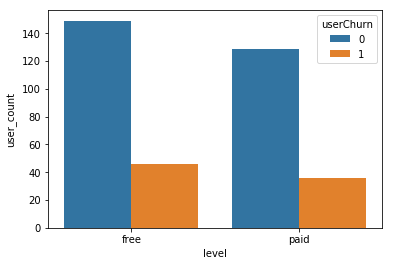

In [170]:
sns.barplot(x = 'level', y = 'user_count', data = user_churn_level.toPandas(), hue = 'userChurn')

### Explorer  gender

In [171]:
genderldf1= spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        where page == "Cancellation Confirmation"
        GROUP BY gender
        ORDER BY user_count DESC
''').show()

+------+----------+
|gender|user_count|
+------+----------+
|     M|        32|
|     F|        20|
+------+----------+



In [172]:

# gender distribution between churn users and regular users
churnedGender1 = df.drop_duplicates(['userId', 'gender']).groupby(['userChurn', 'gender']).count().sort("userChurn").toPandas()
churnedGender1

,userChurn,gender,count
0,0,M,89
1,0,F,84
2,1,F,20
3,1,M,32


In [173]:
churnedGender2 = spark.sql('''
        SELECT userChurn,gender,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        GROUP BY userChurn,gender
        ORDER BY user_count DESC
''')
churnedGender2.show()

+---------+------+----------+
|userChurn|gender|user_count|
+---------+------+----------+
|        0|     M|        89|
|        0|     F|        84|
|        1|     M|        32|
|        1|     F|        20|
+---------+------+----------+



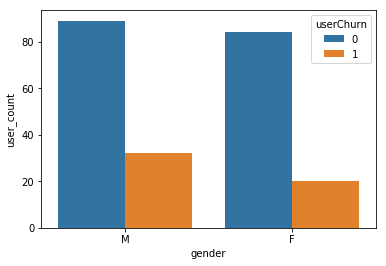

In [174]:
sns.barplot(x = 'gender', y = 'user_count', data = churnedGender2.toPandas(), hue = 'userChurn');

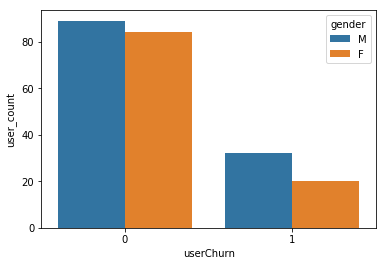

In [175]:
sns.barplot(x = 'userChurn', y = 'user_count', data = churnedGender2.toPandas(), hue = 'gender')

### From above plots and exploration, male users are more likely to cancel their subscribtion (to churn) comparing to female users. Number of male users are greater than female in both chured and non-chured users.

In [176]:
dfp=df.toPandas()

### Explorer page that user visited

In [177]:
churnedpage = spark.sql('''
        SELECT userChurn,page,COUNT(DISTINCT userId) AS user_count
        FROM new_Sparkify
        GROUP BY userChurn,page
        ORDER BY page 
''')
churnedpage.show()

+---------+--------------------+----------+
|userChurn|                page|user_count|
+---------+--------------------+----------+
|        1|               About|        31|
|        0|               About|       124|
|        1|          Add Friend|        44|
|        0|          Add Friend|       162|
|        1|     Add to Playlist|        50|
|        0|     Add to Playlist|       165|
|        1|              Cancel|        52|
|        1|Cancellation Conf...|        52|
|        0|           Downgrade|       119|
|        1|           Downgrade|        35|
|        0|               Error|        95|
|        1|               Error|        22|
|        0|                Help|       149|
|        1|                Help|        43|
|        0|                Home|       172|
|        1|                Home|        51|
|        1|              Logout|        46|
|        0|              Logout|       167|
|        1|            NextSong|        52|
|        0|            NextSong|

In [178]:
df.select(["userChurn", "page"]).groupby(["userChurn", "page"]).count().sort("page").show()

+---------+--------------------+------+
|userChurn|                page| count|
+---------+--------------------+------+
|        1|               About|    56|
|        0|               About|   439|
|        1|          Add Friend|   636|
|        0|          Add Friend|  3641|
|        1|     Add to Playlist|  1038|
|        0|     Add to Playlist|  5488|
|        1|              Cancel|    52|
|        1|Cancellation Conf...|    52|
|        0|           Downgrade|  1718|
|        1|           Downgrade|   337|
|        0|               Error|   220|
|        1|               Error|    32|
|        0|                Help|  1215|
|        1|                Help|   239|
|        0|                Home|  8410|
|        1|                Home|  1672|
|        1|              Logout|   553|
|        0|              Logout|  2673|
|        1|            NextSong| 36394|
|        0|            NextSong|191714|
+---------+--------------------+------+
only showing top 20 rows



In [179]:
userChurned = dfp[dfp.userChurn == 1].groupby(['page'])['userId'].count().drop('NextSong')
userChurned = userChurned /userChurned.sum()*100
userChurned

page
About                         0.661157
Add Friend                    7.508855
Add to Playlist              12.255018
Cancel                        0.613932
Cancellation Confirmation     0.613932
Downgrade                     3.978749
Error                         0.377804
Help                          2.821724
Home                         19.740260
Logout                        6.528926
Roll Advert                  11.416765
Save Settings                 0.684770
Settings                      3.187721
Submit Downgrade              0.106257
Submit Upgrade                0.377804
Thumbs Down                   5.855962
Thumbs Up                    21.948052
Upgrade                       1.322314
Name: userId, dtype: float64

In [180]:
userNotChurned = dfp[dfp.userChurn == 0].groupby(['page'])['userId'].count().drop('NextSong')
userNotChurned = userNotChurned /userNotChurned.sum()*100
userNotChurned

page
About                1.055898
Add Friend           8.757456
Add to Playlist     13.199923
Downgrade            4.132192
Error                0.529151
Help                 2.922359
Home                20.228016
Logout               6.429190
Roll Advert          7.133923
Save Settings        0.606119
Settings             2.992111
Submit Downgrade     0.129883
Submit Upgrade       0.305465
Thumbs Down          4.930729
Thumbs Up           25.716760
Upgrade              0.930825
Name: userId, dtype: float64

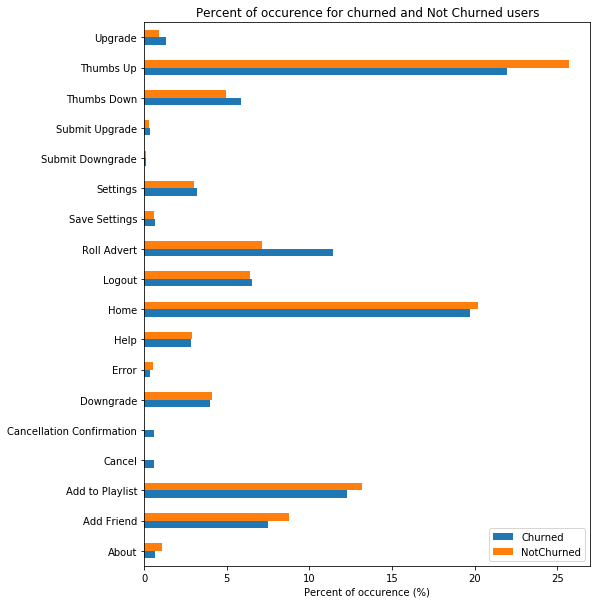

In [181]:
user_pageDf = pd.DataFrame({'Churned': userChurned,'NotChurned':userNotChurned})
#fig, ax = plt.subplots(figsize=(8,8))
ax = user_pageDf.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of occurence (%)')
ax.set_title('Percent of occurence for churned and Not Churned users');

### From the above plot it seems that chured user mostly indicated by Roll Advert, and Thumbs Down, while not-churned users indicated by Thumbs Up, Add Friend and Add to Playlist .

### Exploler Location

In [182]:
df = df.withColumn('city',split(df['location'], ',').getItem(0))
df = df.withColumn('state',split(df['location'], ',').getItem(1))

In [183]:
df.createOrReplaceTempView("new_sparkify")
locChurn=spark.sql(''' select  userChurn,state, COUNT(DISTINCT userId) AS user_count
              From new_sparkify 
              GROUP BY 1,2
              ORDER BY 2''')
locChurn.show()

+---------+------------+----------+
|userChurn|       state|user_count|
+---------+------------+----------+
|        0|          AK|         2|
|        1|          AL|         2|
|        0|          AL|         2|
|        1|          AR|         1|
|        1|          AZ|         2|
|        0|          AZ|         5|
|        0|          CA|        27|
|        1|          CA|         6|
|        0|          CO|         2|
|        1|          CO|         2|
|        0|          CT|         7|
|        1| DC-VA-MD-WV|         1|
|        0| DC-VA-MD-WV|         3|
|        0|          FL|        11|
|        1|          FL|         3|
|        0|          GA|         4|
|        0|       GA-AL|         2|
|        0|          IA|         1|
|        0|          IL|         3|
|        0|    IL-IN-WI|         5|
+---------+------------+----------+
only showing top 20 rows



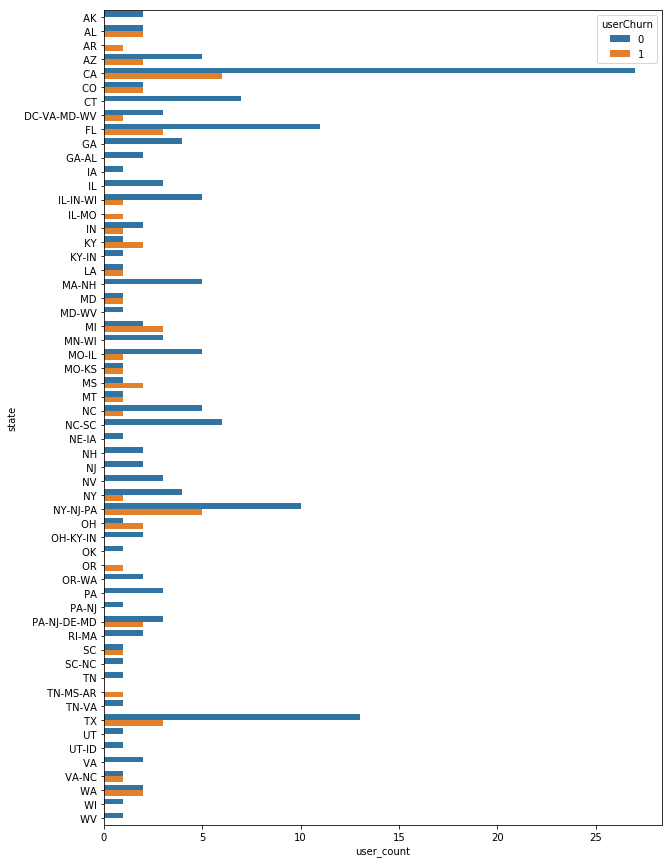

In [184]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(x = 'user_count', y = 'state', data = locChurn.toPandas(), hue = 'userChurn');

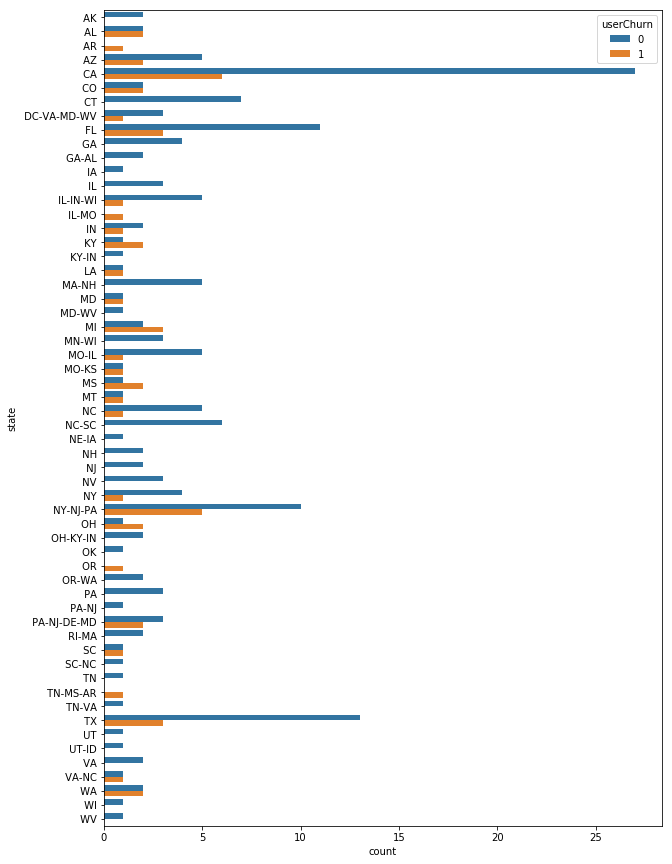

In [185]:
state_data = df.dropDuplicates(["userId"]).groupby(["state","userChurn"]).count().sort("state").toPandas()
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="count",y="state", hue="userChurn", data=state_data,ax=ax);

I think location is not important factor to determin churn and not churn

### Explorer time


In [186]:
# number of song played in each hour
songs_played_inHour = df.filter("page == 'NextSong'").groupBy("new_hour").count().sort(df.new_hour.cast("float")).toPandas()

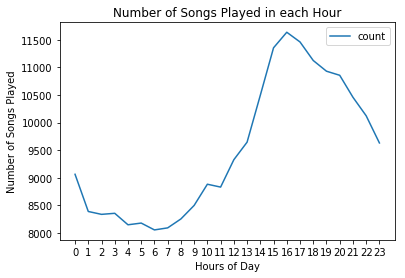

In [187]:
songs_played_inHour.plot.line()
plt.xticks(np.arange(0,24,1))
plt.xlabel("Hours of Day")
plt.ylabel("Number of Songs Played")
plt.title("Number of Songs Played in each Hour")
plt.show()

around 16:00 and 17:00 we see the highest number of songs played

In [188]:
#group by userChurn and new_hour
churnedHour= spark.sql('''
        SELECT userChurn,new_hour, count( DISTINCT userId) as user_count
        FROM new_Sparkify
        WHERE page == 'NextSong'
        GROUP BY  1,2
        ORDER BY  2 ASC
        
''')
churnedHour.show()
churnedHourpd=churnedHour.toPandas()

+---------+--------+----------+
|userChurn|new_hour|user_count|
+---------+--------+----------+
|        0|       0|       137|
|        1|       0|        36|
|        0|       1|       138|
|        1|       1|        34|
|        0|      10|       136|
|        1|      10|        34|
|        0|      11|       138|
|        1|      11|        36|
|        1|      12|        36|
|        0|      12|       144|
|        0|      13|       148|
|        1|      13|        38|
|        0|      14|       149|
|        1|      14|        40|
|        1|      15|        41|
|        0|      15|       152|
|        0|      16|       147|
|        1|      16|        42|
|        0|      17|       145|
|        1|      17|        42|
+---------+--------+----------+
only showing top 20 rows



In [189]:
#try sparksql
#Create a temporary view to perform SQL operations
churnedHour.createOrReplaceTempView("churnedHour")
churnedHour_0= spark.sql('''
        SELECT new_hour, user_count
        FROM churnedHour
        where userChurn==0
        
''')
churnedHour_0.show()

+--------+----------+
|new_hour|user_count|
+--------+----------+
|       0|       137|
|       1|       138|
|      10|       136|
|      11|       138|
|      12|       144|
|      13|       148|
|      14|       149|
|      15|       152|
|      16|       147|
|      17|       145|
|      18|       142|
|      19|       141|
|       2|       140|
|      20|       138|
|      21|       138|
|      22|       141|
|      23|       143|
|       3|       139|
|       4|       137|
|       5|       137|
+--------+----------+
only showing top 20 rows



In [190]:
#try sparksql
#Create a temporary view to perform SQL operations
churnedHour.createOrReplaceTempView("churnedHour")
churnedHour_1= spark.sql('''
        SELECT new_hour, user_count
        FROM churnedHour
        where userChurn==1
        
''')
churnedHour_1.show()

+--------+----------+
|new_hour|user_count|
+--------+----------+
|       0|        36|
|       1|        34|
|      10|        34|
|      11|        36|
|      12|        36|
|      13|        38|
|      14|        40|
|      15|        41|
|      16|        42|
|      17|        42|
|      18|        43|
|      19|        42|
|       2|        36|
|      20|        40|
|      21|        40|
|      22|        38|
|      23|        38|
|       3|        32|
|       4|        35|
|       5|        35|
+--------+----------+
only showing top 20 rows



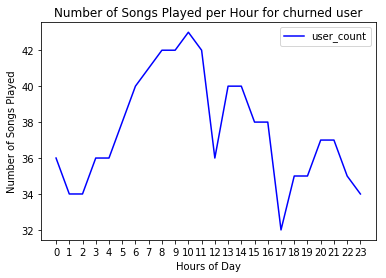

In [191]:
churnedHour_1.toPandas().plot.line(color='Blue')
plt.xticks(np.arange(0,24,1))
plt.xlabel("Hours of Day")
plt.ylabel("Number of Songs Played")
plt.title("Number of Songs Played per Hour for churned user")
plt.show()

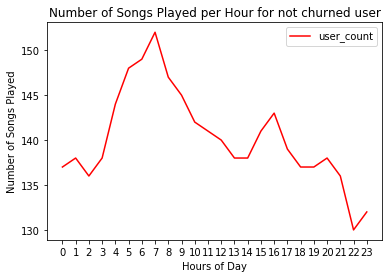

In [192]:
churnedHour_0.toPandas().plot.line(color='red')
plt.xticks(np.arange(0,24,1))
plt.xlabel("Hours of Day")
plt.ylabel("Number of Songs Played")
plt.title("Number of Songs Played per Hour for not churned user")
plt.show()

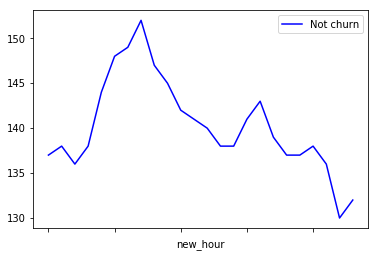

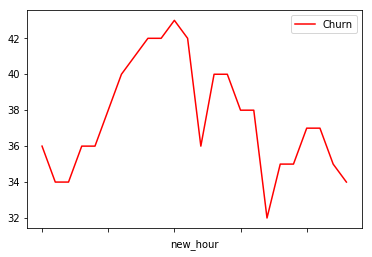

In [193]:
pd_churnedHour_1= churnedHour_1.toPandas()
pd_churnedHour_0= churnedHour_0.toPandas()
pd_churnedHour_0.plot(x= 'new_hour', y='user_count', color='Blue', label='Not churn')
pd_churnedHour_1.plot(x='new_hour', y='user_count', color='Red', label='Churn')


In [194]:

tsData = spark.sql('''
        SELECT new_ts,userId
        FROM new_Sparkify
''').toPandas()
tsData.head()

,new_ts,userId
0,10-01-2018 00:01:57,30
1,10-01-2018 00:03:00,9
2,10-01-2018 00:06:34,30
3,10-01-2018 00:06:56,9
4,10-01-2018 00:11:16,30


In [195]:
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))
df = df.withColumn('dayweek', get_weekday(df.ts))
dayofweek_data = df.select(["userChurn", "dayweek"]).groupby(["userChurn", "dayweek"]).count().sort("dayweek").toPandas()
dayofweek_data

,userChurn,dayweek,count
0,1,0,2528
1,0,0,18522
2,0,1,36301
3,1,1,6951
4,0,2,39700
5,1,2,7664
6,1,3,7291
7,0,3,38677
8,0,4,36631
9,1,4,7689


In [196]:
df.createOrReplaceTempView("new_sparkify")
dayweekChurn=spark.sql(''' select  userChurn,dayweek, COUNT(DISTINCT userId) AS user_count
              From new_sparkify 
              GROUP BY 1,2
              ORDER BY 2''')
dayweekChurn.show()

+---------+-------+----------+
|userChurn|dayweek|user_count|
+---------+-------+----------+
|        0|      0|       109|
|        1|      0|        24|
|        1|      1|        36|
|        0|      1|       139|
|        0|      2|       141|
|        1|      2|        34|
|        1|      3|        36|
|        0|      3|       143|
|        0|      4|       139|
|        1|      4|        39|
|        0|      5|       147|
|        1|      5|        43|
|        1|      6|        38|
|        0|      6|       107|
+---------+-------+----------+



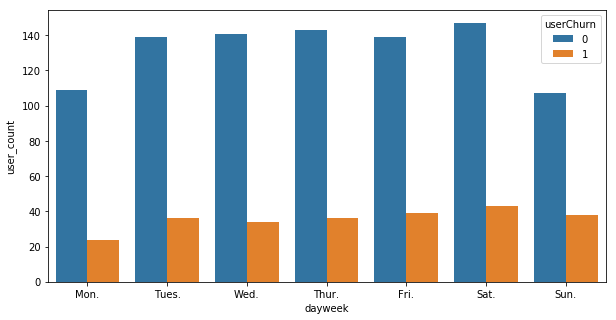

In [197]:
weekday_dict = ['Mon.','Tues.','Wed.','Thur.','Fri.','Sat.','Sun.']
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="dayweek",y="user_count", hue="userChurn", data=dayweekChurn.toPandas(),ax=ax);
ax.set_xticklabels(weekday_dict);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [198]:
#x1:number of artists each user  listened to
x1 = df.filter(df.page == "NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()\
         .withColumnRenamed("count", "totlArtist")
x1.describe().show()

+-------+------------------+-----------------+
|summary|            userId|       totlArtist|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [199]:
#x2:Total length of listening 
x2 = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'TotalListenTime').sort('TotalListenTime')
x2.describe().show()

+-------+------------------+------------------+
|summary|            userId|   TotalListenTime|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336| 252558.3206515555|
| stddev|105396.47791907162| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



In [200]:
# x3:Number of Thumbs-Up
x3 = df.select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID').count().withColumnRenamed('count', 'totalThumb_up') 
x3.describe().show()

+-------+------------------+-----------------+
|summary|            userID|    totalThumb_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [201]:
# x4:Number of Thumbs-Down    
x4 = df.select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID').count().withColumnRenamed('count', 'totalThumb_down')
x4.describe().show()


+-------+------------------+------------------+
|summary|            userID|   totalThumb_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [202]:
#x5:Total number of  songs  
x5 = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'totlSongs')
x5.describe().show()

+-------+------------------+-----------------+
|summary|            userId|        totlSongs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [203]:
#x6:Total time since registration
lifeTimeData= df.select('userId', 'registration', 'ts').withColumn('lifetime', (df.ts - df.registration))
lifeTimeData= lifeTimeData.groupBy('userId').max('lifetime')
lifeTimeData=lifeTimeData.withColumnRenamed('max(lifetime)', 'lifetime')
x6= lifeTimeData.select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
x6.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [204]:
# x7:Total number of churened user per rolladvert 
x7 = df.select('userID','page').where(df.page == 'Roll Advert').groupBy('userID').count().withColumnRenamed('count', 'totalrolladvert') 
x7.describe().show()


+-------+-----------------+-----------------+
|summary|           userID|  totalrolladvert|
+-------+-----------------+-----------------+
|  count|              207|              207|
|   mean|59961.88888888889|             19.0|
| stddev|99417.06206742716|21.81675672015453|
|    min|               10|                1|
|    max|               99|              128|
+-------+-----------------+-----------------+



In [205]:
# x8: Total number of friends    
x8 = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'totlFriends')
x8.describe().show()

+-------+------------------+------------------+
|summary|            userId|       totlFriends|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [206]:
#x9: Gender of each user 
x9 = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))

x9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.5377777777777778|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [207]:
# x10: Total number of songs listening per session
x10  = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId').agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avgPlayedSession')

x10.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avgPlayedSession|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [208]:

# setting the churn label for our model
label = df.select('userId', col('userChurn').alias('label')).dropDuplicates()
label.show()

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



In [209]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- new_registration: string (nullable = true)
 |-- new_ts: string (nullable = true)
 |-- new_hour: string (nullable = true)
 |-- new_month: string (nullable = true)
 |-- new_year: string (nullable = true)
 |-- downgradeValue: integer (nullable = true)
 |-- userDowngrade: integer (nullable = true)
 |-- c

In [210]:
joined_data = x1.join(x2, 'userId', 'inner').join(x3, 'userId', 'inner').join(x4, 'userId', 'inner')\
             .join(x5, 'userId', 'inner').join(x6, 'userId', 'inner').join(x7, 'userId', 'inner')\
             .join(x8, 'userId', 'inner').join(x9, 'userId', 'inner').join(x10, 'userId', 'inner').join(label, 'userId', 'inner').drop('userId')

joined_data.show()

+----------+------------------+-------------+---------------+---------+------------------+---------------+-----------+------+------------------+-----+
|totlArtist|   TotalListenTime|totalThumb_up|totalThumb_down|totlSongs|          lifetime|totalrolladvert|totlFriends|gender|  avgPlayedSession|label|
+----------+------------------+-------------+---------------+---------+------------------+---------------+-----------+------+------------------+-----+
|        26|        5854.89105|            2|              2|       44| 9.127164351851851|              3|          4|     0|              26.0|    1|
|        41| 9482.116939999998|            3|              1|       62|52.816701388888895|              2|          1|     0|13.666666666666666|    1|
|        61|15585.069069999996|            1|              1|       89| 31.19925925925926|             11|          2|     1|              31.0|    1|
|        66|       16472.36843|            3|              1|       84| 65.71107638888888|    

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [211]:
#vectorize all of our features
cols = ['totlArtist','TotalListenTime','totalThumb_up','totalThumb_down','totlSongs','lifetime','totalrolladvert','totlFriends','gender','avgPlayedSession'] 
assembler = VectorAssembler(inputCols = cols, outputCol = "Vect_Features")
joined_data = assembler.transform(joined_data)
joined_data.show()

+----------+------------------+-------------+---------------+---------+------------------+---------------+-----------+------+------------------+-----+--------------------+
|totlArtist|   TotalListenTime|totalThumb_up|totalThumb_down|totlSongs|          lifetime|totalrolladvert|totlFriends|gender|  avgPlayedSession|label|       Vect_Features|
+----------+------------------+-------------+---------------+---------+------------------+---------------+-----------+------+------------------+-----+--------------------+
|        26|        5854.89105|            2|              2|       44| 9.127164351851851|              3|          4|     0|              26.0|    1|[26.0,5854.89105,...|
|        41| 9482.116939999998|            3|              1|       62|52.816701388888895|              2|          1|     0|13.666666666666666|    1|[41.0,9482.116939...|
|        61|15585.069069999996|            1|              1|       89| 31.19925925925926|             11|          2|     1|              3

In [212]:
#Standardizing all input features after vectorizing all features in previous step
scaler = StandardScaler(inputCol = 'Vect_Features', outputCol = "features", withStd = True)
scalerModel = scaler.fit(joined_data)
joined_data = scalerModel.transform(joined_data)

In [213]:
joined_data.show()

+----------+------------------+-------------+---------------+---------+------------------+---------------+-----------+------+------------------+-----+--------------------+--------------------+
|totlArtist|   TotalListenTime|totalThumb_up|totalThumb_down|totlSongs|          lifetime|totalrolladvert|totlFriends|gender|  avgPlayedSession|label|       Vect_Features|            features|
+----------+------------------+-------------+---------------+---------+------------------+---------------+-----------+------+------------------+-----+--------------------+--------------------+
|        26|        5854.89105|            2|              2|       44| 9.127164351851851|              3|          4|     0|              26.0|    1|[26.0,5854.89105,...|[0.04316343324557...|
|        41| 9482.116939999998|            3|              1|       62|52.816701388888895|              2|          1|     0|13.666666666666666|    1|[41.0,9482.116939...|[0.06806541396418...|
|        61|15585.069069999996|    

In [216]:

data = joined_data.select(joined_data.label, joined_data.features)

In [217]:
train, test = data.randomSplit([0.80, 0.20], seed = 42)
train = train.cache()

#### 1 : Gradient Boosted Trees

In [87]:
# 1 : Gradient Boosted Trees
gbt_clf = GBTClassifier(maxIter = 10, maxDepth = 10, seed = 42)

f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')

param_grid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator = gbt_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)

In [89]:
cvmodel_gbt = crossval_gbt.fit(train)
cvmodel_gbt.avgMetrics

[0.776202132442535]

In [91]:

test_gbt = cvmodel_gbt.transform(test)

In [98]:
# evaluation metrics for Gradient Boosted Trees
evaluat = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("F-1 Score: {}".format(evaluat.evaluate(test_gbt, {evaluat.metricName : "accuracy"})))
print("accuracy: {}".format(evaluat.evaluate(test_gbt, {evaluat.metricName : "f1"})))

F-1 Score: 0.7714285714285715
accuracy: 0.7880341880341881


#### 2 : SVM

In [95]:
# 2 : SVM
svm_clf = LinearSVC(maxIter = 15)

f1_evaluat = MulticlassClassificationEvaluator(metricName = 'f1')

param_grid = ParamGridBuilder().build()

crossval_svm = CrossValidator(estimator = svm_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluat, numFolds = 2)

In [96]:
cv_model_svm = crossval_svm.fit(train)
cv_model_svm.avgMetrics

[0.6602434627178453]

In [99]:
test_svm = cv_model_svm.transform(test)

In [117]:
# evaluation metrics for SVM 
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("F-1 Score: {}".format(evaluator.evaluate(test_svm, {evaluator.metricName : "accuracy"})))
print("accuracy: {}".format(evaluator.evaluate(test_svm, {evaluator.metricName : "f1"})))

F-1 Score: 0.8
accuracy: 0.7111111111111111


#### 3: Logistic Regression

In [103]:
#3 : logistic regression
lr = LogisticRegression()
lr_model = lr.fit(train)


In [119]:
# Evaluate Performance on Training Data
lr_summary = lr_model.summary
print('Accuracy: {}'.format(lr_summary.accuracy))
print('recall: {}'.format(lr_summary.weightedRecall))
print('Precision: {}'.format(lr_summary.weightedPrecision))

Accuracy: 0.8111888111888111
recall: 0.8111888111888111
Precision: 0.812407289680017


In [124]:
test_lr = lr_model .transform(test)

In [130]:
# evaluation metrics for logistic regression 
evaluat = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("F-1 Score: {}".format(evaluator.evaluate(test_lr, {evaluat.metricName : "f1"})))
print("The accuracy is {}".format(evaluat.evaluate(test_lr, {evaluat.metricName : "accuracy"})))

F-1 Score: 0.8666666666666667
The accuracy is 0.8857142857142857


#### 4 : Random Forest Classifier

In [108]:
#4 : Random Forest Classifier
rf_clf = RandomForestClassifier()

f1_evaluat = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

cross_val_rf = CrossValidator(estimator = rf_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluat, numFolds = 2)

In [109]:
cv_model_rf = cross_val_rf.fit(train)
cv_model_rf.avgMetrics

[0.8102776364958104]

In [ ]:
test_rf = cv_model_rf.transform(test)

In [113]:
# Getting different evaluation metrics for Random Forest
evaluat = MulticlassClassificationEvaluator(predictionCol = "prediction")
print("The F-1 Score is {}".format(evaluat.evaluate(test_rf, {evaluat.metricName : "f1"})))
print("The accuracy is {}".format(evaluat.evaluate(test_rf, {evaluat.metricName : "accuracy"})))

The F-1 Score is 0.8412942989214176
The accuracy is 0.8571428571428571



##### We trained different classification models performed on our data and RandomForestClassifier with an F-1 score of 0.841 and accuracy of 0.857 and logistic regression with with an F-1 score of 0.866 and accuracy of 0.0.885 clearly are better than others.  we can choose one of these two as our final model and perform hyperparamter tuning to see whether we can improve the model performance.

#### Tuning Hyperparameters for the Gradient logistic Regression and Randon Forest classification model using Grid Search

In [218]:
# Tuning Hyperparameters for Logistic Regression model using Grid Search
lr_model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(lr_model.regParam,[0.01, 0.1]) \
    .addGrid(lr_model.elasticNetParam,[0.0, 0.5]) \
    .addGrid(lr_model.aggregationDepth,[2, 5]) \
    .build()

f1_evaluat = MulticlassClassificationEvaluator(metricName = 'f1')

crossval_lr = CrossValidator(estimator = lr_model, estimatorParamMaps = param_grid, evaluator = f1_evaluat, numFolds = 2)

In [219]:
cv_model_lr = crossval_lr.fit(train)
cv_model_lr.avgMetrics

[0.7189173865759753,
 0.7189173865759753,
 0.7239656264302496,
 0.7239656264302496,
 0.6919467293380337,
 0.6919467293380337,
 0.6624875844690976,
 0.6624875844690976]

In [221]:
test_final = cv_model_lr.transform(test)

In [223]:

# final evaluation metrics for Gradient Boosted Trees
evaluat = MulticlassClassificationEvaluator(predictionCol = "prediction")
print(" F-1 : {}".format(evaluat.evaluate(test_final, {evaluat.metricName : "f1"})))
print(" accuracy : {}".format(evaluat.evaluate(test_final,{evaluat.metricName : "accuracy"}) ))

 F-1 : 0.8666666666666667
 accuracy : 0.8857142857142857


In [225]:
# Tuning Hyperparameters for RandomForest Classifier model using Grid Search
rf_clf = RandomForestClassifier()

f1_evaluat = MulticlassClassificationEvaluator(metricName = 'f1')
paramGrid = (ParamGridBuilder() \
    .addGrid(rf_clf.numTrees, [10, 20])\
    .addGrid(rf_clf.maxDepth, [2, 4, 6])  \
    .build())

crossval_rf = CrossValidator(estimator = rf_clf, estimatorParamMaps = param_grid, evaluator = f1_evaluat, numFolds = 2)

In [226]:
cvmodel_rf = crossval_rf.fit(train)
cvmodel_rf.avgMetrics

[0.8004699954980795,
 0.8004699954980795,
 0.8004699954980795,
 0.8004699954980795,
 0.8004699954980795,
 0.8004699954980795,
 0.8004699954980795,
 0.8004699954980795]

In [227]:
rf_test = cvmodel_rf.transform(test)

In [228]:
# final evaluation metrics for Gradient Boosted Trees
evaluat = MulticlassClassificationEvaluator(predictionCol = "prediction")
print(" F-1 : {}".format(evaluat.evaluate(rf_test, {evaluat.metricName : "f1"})))
print(" accuracy : {}".format(evaluat.evaluate(rf_test,{evaluat.metricName : "accuracy"}) ))

 F-1 : 0.8412942989214176
 accuracy : 0.8571428571428571


### Conclusion
This spark machine learning capstone project was implemented in predicting customer churn. First, all the necessary preprocessing and data wrangeling have been done including  null and duplicate value checking as well as converting time stamp and registration time  to obtain a cleaner data as much as possible. Mostly based on our exploreraation part, We determined  10 features and also the  churn label to creating our model. We trained four different kinds of classification models on our data (including Logistic Regression, Support Vector Machines, RandomForest,  and Gradient Boosted Trees. After comparing the performance of all 4 models and RandomForestClassifier and Logistic regression performed better so they are selected  as our final models to do some grid search to improve the performance of the model.After Tuning Hyperparameters and doing grid search that last about 2 hours, I haven't seen any changes in performance.

####  Improvement Recommendations

I think we can do much work on feature engineering and test some more features and their impacts on creating reliable and accurate model .We can also create much more accurate and reliable model with much more data for training. We also need to be sure that the data we are working on is accurate because inaccurate data can result in wrong predictions.

#### Reflection 

With this  project I got familier with building data science projects on Apache Spark which is necessary for big data applications. Customer churn is one of the greatest threats for all companies and they need to be doing all necessary works to maintain their customers. It was a great experience for me to work with different modules under PySpark and understanding it's  functionality, dataframe and overall architecture. The biggest challenge in this project was to identify features that impacts on how likely whether a customer will churn or not. Determining the right features will largely determine the performance of the model being trained. 

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.